In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mplt
import pandas as pd
import numpy as np
import plotly.express as px
import plotly as ppx
import scipy as scp
from scipy.stats import norm
from BS_Functions import *
import warnings
import sys

warnings.filterwarnings('ignore')
sns.set(style="darkgrid")

# Implementation based on course materials from [MATH3888, University of Sydney]
# Original function provided in class; I studied and annotated it

Black-Scholes Model Variables:
$$S_0 : \text{Stock Price at the time the option is valued} $$
$$S_T : \text{Stock Price at time T}$$
$$K : \text{Strike Price}$$
$$r : \text{Risk-free Rate}$$
$$\sigma : \text{Volatility(annaualised standard deviation of returns of the asset)}$$
$$T:\text{Time to Expiration(Maturity)}$$

What does **Volatility**($\sigma$) mean?
- Annualised standard deviation of (log) returns


How it works?
- Example: $\sigma = 0.25,S_0 = S,T = 1$
- 68% of the time the stock's return lies in $Se^{\pm0.25}$
- 95% of the time the stock's return lies in $Se^{\pm0.50}$


Why it matters?
- higher volatility means higher opportunity to earn more money
- it affects price on options always in a positive way


How $r$ affects returns?
 - $r$ is a device that kills arbitrage in **Risk-Neutral World**, meaning no matter how you build your strategies, the estimated return will be the same as put money in a bank with interest rate r. This will not happen in real life.


Drifts
 - Things like $r$ will have an impact on return, we call these factors **Drifts**, using symbol $\mu$
$$
m = (\mu - \tfrac{1}{2}\sigma^2)T.
$$
After transforming to $m$, the new interval of return become $Se^{m\pm0.50}$


In [ ]:
def BS_Call_E(S, K, T, r, sig):
    d1 = (np.log(S/K) + (r + 0.5 * sig**2)*T) / (sig*np.sqrt(T))
    d2 = d1 - sig * np.sqrt(T)
    return (S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2))

European Call Price:
$$
C(S_0, K, T, r, \sigma) = S_0 \, \Phi(d_1) - K e^{-rT} \, \Phi(d_2),
$$

$$
d_1 = \frac{\ln\!\left(\tfrac{S_0}{K}\right) + \left(r + \tfrac{1}{2}\sigma^2\right)T}{\sigma \sqrt{T}},
\qquad
d_2 = d_1 - \sigma \sqrt{T},
$$

where $\Phi(\cdot)$ is the CDF of the standard normal distribution.

$$
\Phi(x) = \int_{-\infty}^{x} \frac{1}{\sqrt{2\pi}} \, e^{-\tfrac{1}{2} z^2} \, dz
$$

- **European Call Option** gives the holder the right to **buy** the underlying asset at Strike Price $K$ **only at maturity $T$**.
- But the holder can **Sell the option** as a whole before maturity $T$ instead.

In [ ]:
def BS_Put_E(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return (-S * norm.cdf(-d1) + K * np.exp(-r*T) * norm.cdf(-d2))

European Put Option:
$$
P(S_0, K, T, r, \sigma) \;=\; K e^{-rT} \, \Phi(-d_2) \;-\; S_0 \, \Phi(-d_1),
$$

$$
d_1 = \frac{\ln\!\left(\tfrac{S_0}{K}\right) + \left(r + \tfrac{1}{2}\sigma^2\right)T}{\sigma \sqrt{T}},
\qquad
d_2 = d_1 - \sigma \sqrt{T},
$$

From this formula it is noticeable that:
$$
C(S_0, K, T, r, \sigma) \;-\; P(S_0, K, T, r, \sigma)
\;=\; S_0 \;-\; K e^{-rT}.
$$
We call this Put-Call Parity.\
At $T=0$, parity reduces to the payoff identity:
$$
\max(S_T - K, \, 0) \;-\; \max(K - S_T, \, 0) \;=\; S_T - K
$$

- **European Put Option** gives the holder the right to **sell** the underlying asset at Strike Price $K$ **only at maturity $T$**.
- But the holder can **Sell the option** as a whole before maturity $T$ instead

In [ ]:
def BS_Implied_Vol(target_value, S, K, T, r ):  #, *args
    MAX_ITERATIONS = 200   # max loop iterations
    PRECISION = 1.0e-5     # acceptable error tolerance
    sigma = 0.5            # initial guess for volatility (50%)

    for i in range(0, MAX_ITERATIONS):
        price = BS_Call_E(S, K, T, r, sigma)
        vega = BS_Vega(S, K, T, r, sigma)

        diff = target_value - price  # our root

        if (abs(diff) < PRECISION):
            return sigma

        sigma = sigma + diff/vega # f(x) / f'(x)

    return sigma # value wasn't found, return best guess so far

This function is **Newton–Raphson root-finding algorithm** to solve **Implied Volatility** in the Black-Scholes model.


Why is it helpful?
- **Market standard**: Options are typically quoted in terms of IV rather than raw price.
- **Forward-looking measure**: We cannot observe future volatility directly; IV is the market’s estimate, embedded in option prices.
- **Trading signal**:
  - If you expect future (realized) volatility to be **higher** than current IV, you would **buy options** (long vol).
  - If you expect future volatility to be **lower** than current IV, you would **sell options** (short vol).
- **Link to Vega**: Since Vega > 0 for both calls and puts, option prices increase when volatility increases.
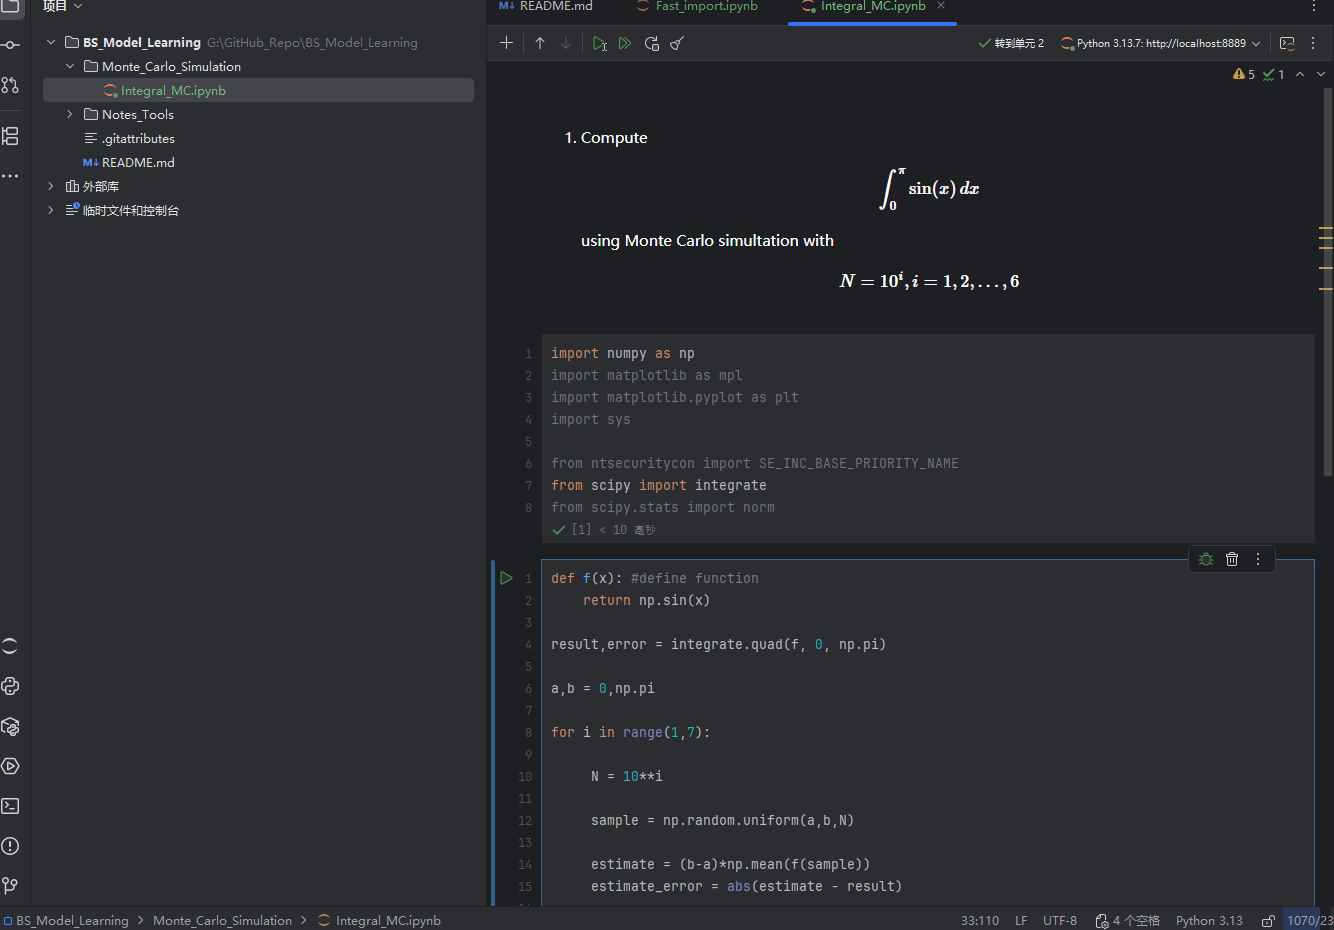

In [ ]:
def BS_Vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

$$
\text{Vega} \;=\; \frac{\partial C}{\partial \sigma} \;=\; \frac{\partial P}{\partial \sigma}
$$
$$
\text{Vega} = S_0 \, \varphi(d_1) \, \sqrt{T}
$$

$\phi$ here is the normal pdf
$$
\varphi(x) \;=\; \frac{1}{\sqrt{2\pi}}\,e^{-\tfrac12 x^2}.
$$
- Vega measures the sensitivity of the option's price to changes in the volatility $\sigma$ of the underlying asset.
- Vega is always positive.
- Vega is the same for both Call and Put options

In [ ]:
def BS_Vomma(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    return BS_Vega(S, K, T, r, sigma) * (d1 * d2 / sigma)

$$
\text{Vomma} \;=\; \frac{\partial^2 C}{\partial \sigma^2}\;=\; \frac{\partial^2 P}{\partial \sigma^2}
$$
$$
\text{Vomma} \;=\; \text{Vega} \cdot \frac{d_1 \, d_2}{\sigma},
$$

Why Vega and Vomma are useful?
- Vega
  - For different types of traders, vega helps them to decide which option to buy
    - Conservative traders(Risk-Averse)
        - They typically avoid options with high Vega (e.g., at-the-money, long-dated contracts).
        - Reason: large Vega means the option’s value can fluctuate strongly with volatility shocks, creating unstable risk exposure.
        - Instead, they may choose deep in-the-money or out-of-the-money options, where Vega is smaller and volatility exposure is weaker.
    - Aggressive traders (Risk-Seeking)
        - They often seek out high-Vega options.
        -Reason: when volatility rises, these options respond most strongly, magnifying potential gains.
        - High-Vega positions are riskier but offer greater upside if the trader’s volatility forecast is correct.
  - Risk measurement and control
    - Trading desks at banks or hedge funds may hold thousands of options.
    - Vega provides a clear measure of the portfolio’s exposure to changes in volatility.
    - Example: \\$20,000 Vega” means a 1% rise in implied volatility will increase the portfolio’s value by about \\$20,000.
    - This allows risk managers to monitor and set volatility risk limits across traders.


In [ ]:
def BS_Barrier_CDI(S,K,Barrier,T,r,sigma):

    barr_lambda = ((r) + (sigma**2/2))/sigma**2
    barr_y = np.log(Barrier**2/(S*K))/(sigma*np.sqrt(T)) + barr_lambda*sigma*np.sqrt(T)
    CDI = S*(Barrier/S)**(2*barr_lambda)*norm.cdf(barr_y) - K*np.exp(-r*T)*(Barrier/S)**(2*barr_lambda-2)*norm.cdf(barr_y-sigma*np.sqrt(T))

    return     CDI


def BS_Barrier_CDO(S,K,Barrier,T,r,sigma):

    barr_lambda = ((r) + (sigma**2/2))/sigma**2
    barr_y = np.log(Barrier**2/(S*K))/(sigma*np.sqrt(T)) + barr_lambda*sigma*np.sqrt(T)
    CDI = S*(Barrier/S)**(2*barr_lambda)*norm.cdf(barr_y) - K*np.exp(-r*T)*(Barrier/S)**(2*barr_lambda-2)*norm.cdf(barr_y-sigma*np.sqrt(T))

    CDO = BS_Call_E(S, K, T, r, sigma) - CDI

    return     CDO

Down-and-In and Down-and-Out Call options
$$
\text{CDI}+\text{CDO} = \text{European Call}
$$
- The value of the Barrier option based on if the asset 'touches' some Barrier
  - If barrier never touched
    - CDI = 0
    - CDO = European Call
  - If Barrier touched
    - CDI = European Call
    - CDO = 0